In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [2]:
current_path = os.getcwd()

rose_folder = 'rose'
sunflower_folder = 'sunflower'

rose_path = pathlib.Path(os.path.join(current_path, rose_folder))
sunflower_path = pathlib.Path(os.path.join(current_path, sunflower_folder))

rose_files = [x for x in rose_path.iterdir() if x.is_file()]
sunflower_files = [x for x in sunflower_path.iterdir() if x.is_file()]

<class 'numpy.ndarray'>


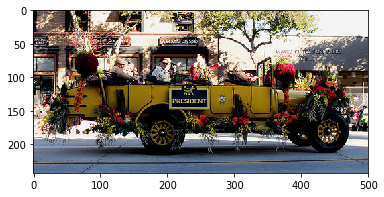

In [5]:
for img_path in rose_files:
    img = plt.imread(img_path)
    plt.imshow(img)
    break